In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import *
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.utils import to_categorical
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from keras.utils import to_categorical
from keras.callbacks import *

import os

import PIL

np.random.seed(2018)
data_path = './'
checkpoint_string = 'bst_model_weights.h5'

n_folds = 5

Using TensorFlow backend.


In [2]:
def read_and_resize_single_img(filename,nrow=224,ncol=224,channels=3):
    from scipy import misc
    arr = misc.imread(filename)
    arr = misc.imresize(arr,size=(nrow,ncol,channels))
    return arr

def read_train_from_dirs(path = './input/train',num_imgs_per_class=5,skip=0,nrow=224,ncol=224,channels=3):
    import glob
    filelist = glob.glob(path + '*/*.jpg')
    categories = [l.split('\\')[-2] for l in filelist]
    k2v = {i:l for i,l in enumerate(np.unique(categories))}
    v2k = {l:i for i,l in enumerate(np.unique(categories))}
    l = [[t,v2k[t]] for t in categories]
    labels_df = pd.DataFrame(l,columns=['category','cat_num'])
    labels_df['filenames'] = filelist
    labels_indexes = np.array([np.where(labels_df.cat_num==c)[0][skip:skip+num_imgs_per_class] 
                               for c in labels_df.cat_num.unique()[:20]])
    filtered = labels_df.iloc[labels_indexes.flatten(),:]
    num_imgs = filtered.shape[0]
    X = np.zeros((num_imgs,nrow,ncol,channels))
    for i in range(filtered.shape[0]):
        arr=read_and_resize_single_img(filtered.loc[:,'filenames'].iloc[i],nrow,ncol,channels)
        if len(arr.shape)<3: arr = np.stack([arr,arr,arr],axis=-1) #change to use np.repeat() for more generalizable
        X[i] = np.float16(arr)
    y = filtered.loc[:,'cat_num'].values
    return X,y,k2v,v2k

In [3]:
def plot_multiple_imgs(data,nrows=4,ncols=4,figsize=(18,18)):
    fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    for i in range(nrows*ncols):
        ax[i%nrows,i//nrows].imshow(data[i])

In [4]:
def save_model(model,filename):
    # this is a helper function used to save a keras NN model architecture and weights
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', filename+'_architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join('cache', filename+'_model_weights.h5'), overwrite=True)
    
def read_model(filename):
    # this is a helper function used to restore a keras NN model architecture and weights
    model = model_from_json(open(os.path.join('cache', filename+'_architecture.json')).read())
    model.load_weights(os.path.join('cache', filename+'_model_weights.h5'))
    return model

In [5]:
def set_callbacks(description='run1',patience=3,tb_base_logdir='./logs/'):
    cp = ModelCheckpoint('best_model_weights_{}.h5'.format(description),save_best_only=True)
    es = EarlyStopping(patience=patience,monitor='val_acc')   
    log = CSVLogger('csv_logs/{}/train_log.csv'.format(description))
    tb = TensorBoard(log_dir='{}{}'.format(tb_base_logdir,description))
    cb = [cp,es,log,tb]
    return cb

In [6]:
%%time
num_tr_imgs = 1300
num_val_imgs = 500
num_te_imgs = 500
X_train,y_train,k2v,v2k = read_train_from_dirs(path='C:/Users/user/natis_folder/kaggle/state_farm/train/',
                                               num_imgs_per_class=num_tr_imgs)
X_val,y_val,_,_ = read_train_from_dirs(path='C:/Users/user/natis_folder/kaggle/state_farm/train/',
                                       num_imgs_per_class=10,skip=num_tr_imgs)

C:\Users\user\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()
C:\Users\user\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Wall time: 2min 16s


array([[[ 31.,  36.,  27.],
        [ 35.,  36.,  38.],
        [ 38.,  39.,  38.],
        ...,
        [106., 181., 202.],
        [127., 196., 202.],
        [187., 238., 236.]],

       [[ 32.,  42.,  32.],
        [ 33.,  40.,  40.],
        [ 36.,  41.,  38.],
        ...,
        [127., 204., 221.],
        [170., 240., 244.],
        [196., 250., 249.]],

       [[ 28.,  44.,  33.],
        [ 26.,  39.,  38.],
        [ 23.,  35.,  30.],
        ...,
        [160., 240., 248.],
        [159., 237., 239.],
        [156., 220., 220.]],

       ...,

       [[ 37.,  56.,  46.],
        [ 40.,  58.,  50.],
        [ 43.,  59.,  53.],
        ...,
        [ 15.,  14.,  12.],
        [ 15.,  14.,  12.],
        [ 13.,  12.,  10.]],

       [[ 37.,  59.,  48.],
        [ 38.,  58.,  49.],
        [ 43.,  61.,  54.],
        ...,
        [ 16.,  15.,  13.],
        [ 13.,  12.,  10.],
        [ 12.,  11.,   9.]],

       [[ 66.,  90.,  78.],
        [ 48.,  69.,  60.],
        [ 44.,  

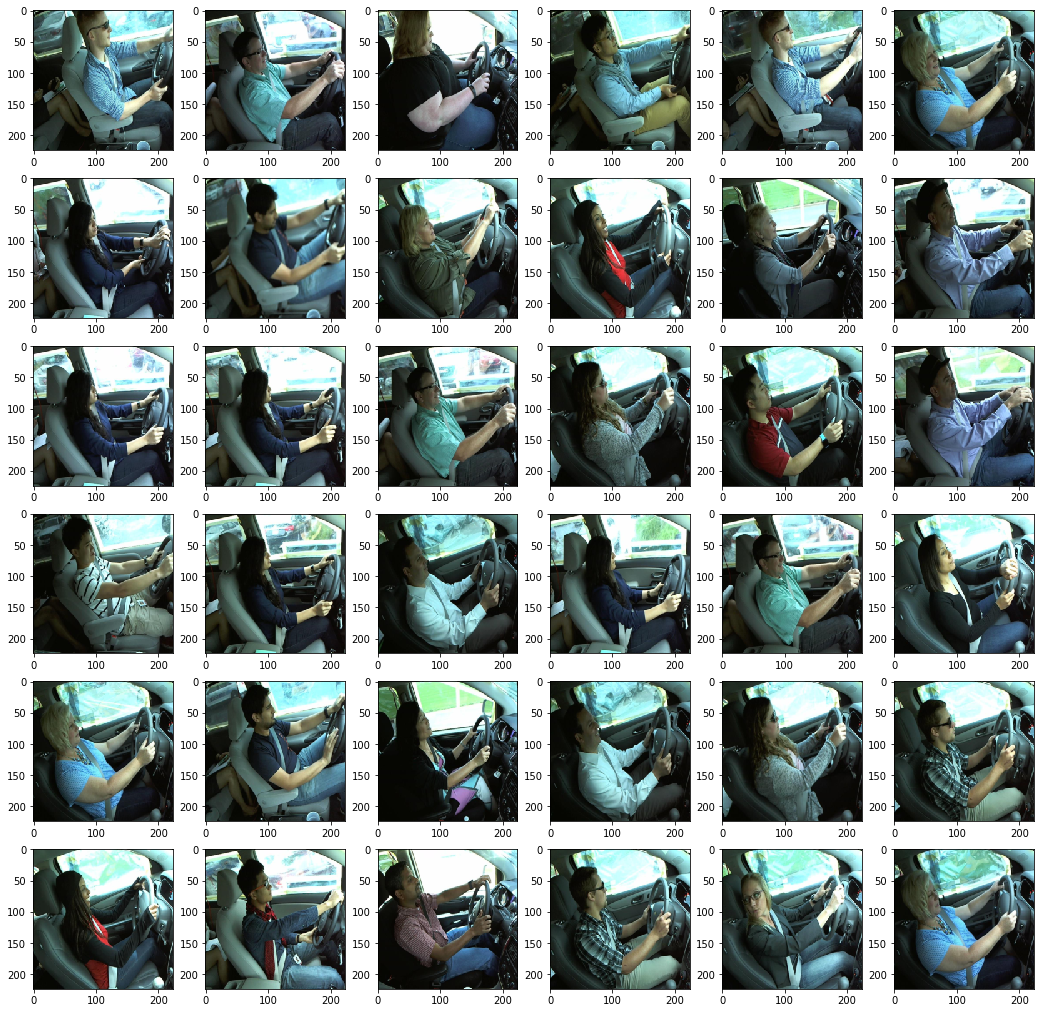

In [9]:
plot_multiple_imgs(X_train/255,6,6)

In [15]:
def get_model_all_classes():
    vgg16 = VGG16(weights='imagenet', include_top=True)
    vgg16.summary()
    for l in vgg16.layers:
        l.trainable = False

    x = GlobalAveragePooling2D()(vgg16.layers[-5].output)
    x = Dropout(0.3)(x)
#     x = Flatten()(x)
    x = Dense(to_categorical(range(10)).shape[1],activation='softmax',name = 'predictions')(x)
    model = Model(inputs = vgg16.input,outputs = x)
    model.summary()
    return model

In [16]:
model = get_model_all_classes()
model.compile(loss='categorical_crossentropy',optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
model.fit(X_train,to_categorical(y_train),validation_data=[X_val,to_categorical(y_val)],epochs=10,batch_size=8)

Train on 13000 samples, validate on 100 samples
Epoch 1/10
13000/13000 [==============================] - 435s 33ms/step - loss: 4.0912 - val_loss: 0.5005
Epoch 2/10
13000/13000 [==============================] - 431s 33ms/step - loss: 1.1406 - val_loss: 0.1938
Epoch 3/10
13000/13000 [==============================] - 432s 33ms/step - loss: 0.9614 - val_loss: 0.1740
Epoch 4/10
13000/13000 [==============================] - 432s 33ms/step - loss: 0.9262 - val_loss: 0.1937
Epoch 5/10
13000/13000 [==============================] - 432s 33ms/step - loss: 0.9232 - val_loss: 0.1767
Epoch 6/10
13000/13000 [==============================] - 432s 33ms/step - loss: 0.9170 - val_loss: 0.1394
Epoch 7/10
13000/13000 [==============================] - 432s 33ms/step - loss: 0.9101 - val_loss: 0.2628
Epoch 8/10
13000/13000 [==============================] - 431s 33ms/step - loss: 0.9456 - val_loss: 0.1281
Epoch 9/10
13000/13000 [==============================] - 432s 33ms/step - loss: 0.9498 - val_lo

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
save_model(model,'vgg16_transfer_random_validation')